# Compute daily means on CNCRM5-LE

In [4]:
import numpy as np
import xarray as xr
import subprocess
import multiprocessing
from multiprocessing import Pool
import time
import dask
# my function files
import functions_preprocessing as fp

In [35]:
## Parameters
# Variable
var = 'tas'
# Period
year_range = [1955,1955]
# Number of ensemble members
memb_range = [50,50]
# Months
mon_range = [1,12]

# Settings
# Encoding (for compressing netcdf output)
encoding_netcdf = {
    var: {
        'zlib': 'True',  # Use gzip compression
        'complevel': 1,  # Compression level (1-9)
        'dtype': 'float32'      # Optionally change data type to reduce size
    }
}
# Number of processors
nproc = 4

complevel 1

OPT 1

In [ ]:

def save_daily_mean(file_in, file_out, namevar, encoding):
    """ Function takes computes and saves the daily mean values of variable.
    Args:
    file_in (str): input file.
    file_out (str): output file.
    namevar (str): variable on which to compute daily mean.
    encoding (dict): encoding options for saving the dataset.
    """
    # Load the dataset
    ds = xr.open_dataset(file_in)
    # Resample to daily means
    daily_means = ds[namevar].resample(time='1D').mean(dim='time')
    # Adapt dataset
    ds_daily = ds.isel(time=slice(0,len(daily_means['time'].values))).assign_coords(time=daily_means.time)
    ds_daily[namevar] = daily_means
    # Save daily means dataset 
    ds_daily.to_netcdf(file_out, encoding=encoding)
    return

# Loop over ensemble members, years, months
# st = time.time()
for memb in range(memb_range[0],memb_range[1]+1):
    # Generate list strings
    files_3h = [
        fp.path_file_CRCM5(var, memb, year, mon, time_res='3h')
        for year in range(year_range[0], year_range[1] + 1)
        for mon in range(mon_range[0], mon_range[1] + 1)
    ]
    files_daily = [
        fp.path_file_CRCM5(var, memb, year, mon, time_res='daily')
        for year in range(year_range[0], year_range[1] + 1)
        for mon in range(mon_range[0], mon_range[1] + 1)
    ]
    nfiles = len(files_3h)
    # Compute and save daily mean (parallelized)
    inputs_funct = zip(files_3h, files_daily, 
                       ['tas']*nfiles, [encoding_netcdf]*nfiles)
    with Pool(nproc) as p:
        p.starmap(save_daily_mean,inputs_funct) 
    ## 12 cpus (nproc) with tintin: 175 sec per year data

OPT 2

/home/portal/anaconda3/envs/myenv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42823 instead
  warnings.warn(


Time:  372.84290194511414


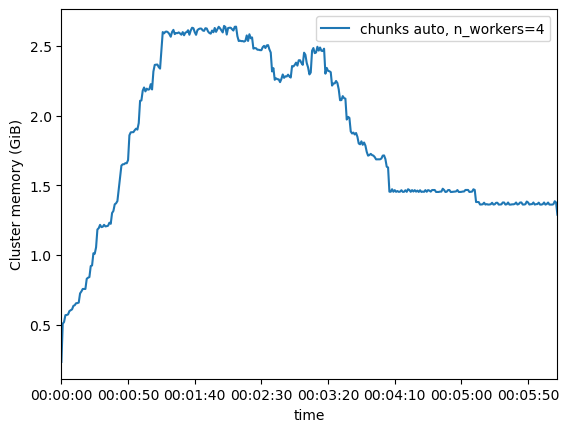

In [45]:
# Function to compute daily mean and save to NetCDF
def compute_and_save_daily_mean(file_path, output_path, variable_name, encoding):
    # Load the dataset
    ds = xr.open_dataset(file_path, chunks={'time': 'auto'})  # Use Dask for chunking

    # Compute daily mean
    ds_daily_mean = ds[variable_name].resample(time='1D').mean()

    # Save the daily mean dataset to a new NetCDF file
    ds_daily_mean.to_netcdf(output_path, encoding=encoding)
    # Function to compute daily mean and save to NetCDF

if __name__ == "__main__":
    
    from dask.distributed import LocalCluster, Client, progress
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)
    from distributed.diagnostics import MemorySampler
    ms = MemorySampler()
    
    for memb in range(memb_range[0],memb_range[1]+1):
        # Generate list strings
        files_3h = [
            fp.path_file_CRCM5(var, memb, year, mon, time_res='3h')
            for year in range(year_range[0], year_range[1] + 1)
            for mon in range(mon_range[0], mon_range[1] + 1)
        ]
        files_daily = [
            fp.path_file_CRCM5(var, memb, year, mon, time_res='daily_try')
            for year in range(year_range[0], year_range[1] + 1)
            for mon in range(mon_range[0], mon_range[1] + 1)
        ]
        nfiles = len(files_3h)
    
        # Use Dask to parallelize the loading, processing, and saving of files
        st = time.time()
        with ms.sample("chunks auto, n_workers=4"):
            dask.compute(
                *[dask.delayed(compute_and_save_daily_mean)(file_in, file_out, var, encoding_netcdf) 
                  for file_in, file_out in zip(files_3h, files_daily)]
            )
        print('Time: ',time.time()-st) ## TIME
        ## duration 1 year: 292 sec
        ## duration 1 years, on tintin giving 12 cpus: 383 sec
        ## duration 1 year, dask with n_workers=16: 128 sec
        ## duration 1 year, dask with n_workers=4: 277 sec
        ## duration 1 year, dask with n_workers=12, no chunking: 334 sec
        ## duration 1 year, dask with n_workers=12, auto chunking: 120 sec
    client.shutdown()
    cluster.close()
    ms.plot(align=True)

OPT 3

In [42]:
ds = xr.open_mfdataset(files_3h[1], chunks={'time': 'auto'})
print(ds)

<xarray.Dataset>
Dimensions:       (height: 1, rlat: 280, rlon: 280, time: 224)
Coordinates:
  * height        (height) float64 2.0
    lat           (rlat, rlon) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
  * rlat          (rlat) float64 -16.77 -16.66 -16.55 ... 13.7 13.81 13.92
  * rlon          (rlon) float64 -21.66 -21.55 -21.44 ... 8.805 8.915 9.025
  * time          (time) object 1955-02-01 00:00:00 ... 1955-02-28 21:00:00
Data variables:
    rotated_pole  |S1 ...
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(224, 280, 280), meta=np.ndarray>
Attributes: (12/21)
    Conventions:                    CF-1.6 
    contact:                        leduc.martin@ouranos.ca 
    creation_date:                  2016 
    experiment_id:                  kcx
    driving_experiment:             CanESM2 historical-r5 r10i1p1 
    driving_model_id:               CCCma-CanES

In [33]:
# Function to save to NetCDF
def save_monthly(ds_month,namefile,encoding):
    # Save to netcdf
    ds_month.to_netcdf(namefile, encoding=encoding)
    print('Saved: '+namefile)
    return

if __name__ == "__main__":
    
    from dask.distributed import LocalCluster, Client, progress
    cluster = LocalCluster(n_workers=4)
    client = Client(cluster)
    from distributed.diagnostics import MemorySampler
    ms = MemorySampler()
    
    for memb in range(memb_range[0],memb_range[1]+1):
        # Generate list strings
        files_3h = [
            fp.path_file_CRCM5(var, memb, year, mon, time_res='3h')
            for year in range(year_range[0], year_range[1] + 1)
            for mon in range(mon_range[0], mon_range[1] + 1)
        ]
        files_daily = [
            fp.path_file_CRCM5(var, memb, year, mon, time_res='daily_try1')
            for year in range(year_range[0], year_range[1] + 1)
            for mon in range(mon_range[0], mon_range[1] + 1)
        ]
        nfiles = len(files_3h)
    
        # Use Dask to parallelize the loading, processing, and saving of files
        st = time.time()
        ds = xr.open_mfdataset(files_3h, chunks={'time': 'auto'})
        ds_daily_bymonth = ds[var].resample(time='1D').mean().resample(time='1M')
        with ms.sample("chunks 248, n_workers=12"):
            dask.compute(
                *[dask.delayed(save_monthly)(ds_month, files_daily[im], encoding_netcdf) 
                  for im, ds_month in enumerate(ds_daily_bymonth)]
            )
        print('Time: ',time.time()-st) ## TIME
        ## duration 1 year: 292 sec
        ## duration 1 years, on tintin giving 12 cpus: 383 sec
        ## duration 1 year, dask with n_workers=16: 128 sec
        ## duration 1 year, dask with n_workers=4: 277 sec
        ## duration 1 year, dask with n_workers=12, no chunking: 334 sec
        ## duration 1 year, dask with n_workers=12, auto chunking: 120 sec
    client.shutdown()
    cluster.close()
    ms.plot(align=True)

<xarray.DataArray 'tas' (time: 248, rlat: 280, rlon: 280)>
dask.array<open_dataset-3e53d80b46637f003dc5a056705f49adtas, shape=(248, 280, 280), dtype=float32, chunksize=(126, 280, 280), chunktype=numpy.ndarray>
Coordinates:
    lat      (rlat, rlon) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (rlat, rlon) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
  * rlat     (rlat) float64 -16.77 -16.66 -16.55 -16.44 ... 13.7 13.81 13.92
  * rlon     (rlon) float64 -21.66 -21.55 -21.44 -21.33 ... 8.805 8.915 9.025
  * time     (time) object 1955-01-01 00:00:00 ... 1955-01-31 21:00:00
Attributes:
    units:          K
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    realm:          atmos
    cell_measures:  area: areacella
    grid_mapping:   rotated_pole
    level_desc:     Height
    cell_methods:   time: point


Attivare cluster dask per la funzione "to_netcdf"

Chunking importante: ogni chunk di multipli di 6 (3*6h = 1 gg)

Massima lunghezza di ogni singolo file 

from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=16)
client = Client(cluster)
client.shutdown()
cluster.close()

Memory sampler to understand memory usage
from dask.distributed.diagnostics import MemorySampler

memory monitoring is always operating
                ms = MemorySampler()
                with ms.sample('chunk'):
                    w_job = write_job.persist()
                    progress(w_job)
                    del w_job
                array_data = np.array(vars(ms)['samples']['chunk'])
                avg_mem = np.mean(array_data[:, 1])/1e9
                max_mem = np.max(array_data[:, 1])/1e9
                self.logger.info('Avg memory used: %.2f GiB, Peak memory used: %.2f GiB', avg_mem, max_mem)

Dask per tutte le operazioni

loop sugli anni e i membri di ensemble da bash, prende come argomento l'anno e il membro

if __main==__main
Per usare dask in parallelo

In [30]:
def save_monthly(ds_month,namefile,encoding):
    # Save to netcdf
    ds_month.to_netcdf(namefile, encoding=encoding)
    print('Saved: '+namefile)
    return

# Loop over ensemble members
# st = time.time()
for memb in range(memb_range[0],memb_range[1]+1):
    # Generate list strings
    files_3h = [
        fp.path_file_CRCM5(var, memb, year, mon, time_res='3h')
        for year in range(year_range[0], year_range[1] + 1)
        for mon in range(mon_range[0], mon_range[1] + 1)
    ]
    files_daily = [
        fp.path_file_CRCM5(var, memb, year, mon, time_res='daily')
        for year in range(year_range[0], year_range[1] + 1)
        for mon in range(mon_range[0], mon_range[1] + 1)
    ]
    nfiles = len(files_3h)
    ####
    # Open 3h files
    ds_3h = xr.open_mfdataset(files_3h, parallel=True, chunks={'time': 'auto'})
    # Compute daily mean
    ds_daily_bymonth = ds_3h.resample(time='1D').mean().resample(time='1M')
    print('Time daily mean: ',time.time()-st) ## TIME
    # Save daily mean in monthly netcdf files
    st = time.time()
    # Use a multiprocessing Pool to save files in parallel
    with Pool(nproc) as pool:
        pool.starmap(save_monthly, [(ds_month[1], files_daily[im], encoding_netcdf) for im, ds_month in enumerate(ds_daily_bymonth)])
    print('Time save: ',time.time()-st) ## TIME


# non pervenuto
    

Time load:  7.256423234939575
Time daily mean:  0.9726977348327637
DatasetResample, grouped over '__resample_dim__'
12 groups with labels 1955-01-31, 00:00:00, ..., 195....


KeyboardInterrupt: 

Time:  291.93151569366455
